[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/comp-neural-circuits/plasticity-workshop/blob/dev/rate_based.ipynb)

# Rate-based Plasticity Rules

## Hebbian Plasticity

**Goals**
+ Covariance-based learning rule is equivalent to detecting the first principal component of the activity


### Initialization

In [6]:
!pip install numpy scipy matplotlib ipywidgets scikit-learn --quiet
import numpy as np
import scipy.linalg as lin
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
plt.style.use("https://github.com/comp-neural-circuits/plasticity-workshop/raw/dev/plots_style.txt")

### Utility Functions

In [19]:
def ornstein_uhlenbeck(mean,cov,dt,Ttot,dts=1E-2):
  """
  Generates a multi-dimensional Ornstein-Uhlenbeck process.

  Parameters :
  mean (numpy vector) : desired mean
  cov  (matrix)   : covariance matrix (symmetric, positive definite)
  dt   (real)     : timestep output
  Tot  (real)     : total time
  dts = 1E-3 (real) : simulation timestep

  Returns :
  times (numpy vector)
  rates (numpy matrix)  :  rates[i,j] is the rate of unit i at time times[j]
  """
  times = np.linspace(0.0,Ttot-dt,num=int(Ttot/dt))
  n = len(mean)
  nTs = int(Ttot/dts)
  rates_all = np.empty((n,nTs))
  rates_all[:,0] = mean
  L = lin.cholesky(cov)
  nskip = int(dt/dts)
  assert round(dts*nskip,5) == dt , "dt must be multiple of  " + str(dts)
  for t in range(1,nTs):
    dr = dts*(mean-rates_all[:,t-1])
    dpsi = np.sqrt(2*dts)*(L.T @ rng.standard_normal(n))
    rates_all[:,t] = rates_all[:,t-1] + dr + dpsi
  # subsample 
  rates = rates_all[:,::nskip]
  return times,rates
  
def twodimensional_UL(mean1,var1,mean2,var2,corr,dt,Ttot,dts=1E-2):
  """
  Generates samples from a 2D Ornstein-Uhlenbeck process.

  Parameters :
  mean1 (real) : mean on first dimension
  var1  (real) : variance on first dimension (at dt=1. intervals)
  mean2 (real) : - 
  var2  (real) : - 
  corr  (real) : correlation coefficient 
  dt   (real)     : timestep output
  Tot  (real)     : total time
  dts = 1E-3 (real) : simulation timestep

  Returns :
  times  (numpy vector)
  rates1 (numpy vector)
  rates2 (numpy vector)
  """
  assert -1<=corr<=1, "correlation must be in (-1,1) interval"
  var12 = corr*var1*var2
  (times, rates) = ornstein_uhlenbeck(
      np.array([mean1,mean2]),
      np.array([[var1,var12],[var12,var2]]),
      dt,Ttot,dts)
  return times, rates[0,:],rates[1,:]


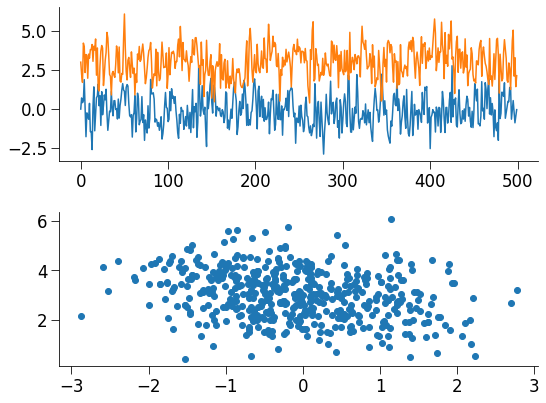

In [20]:
times,rates1,rates2 = twodimensional_UL(0.,1.,3.,1.,-0.33,1.0,500.0)
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(times,rates1)
ax1.plot(times,rates2)
ax2.scatter(rates1,rates2)

In [21]:
@interact(corr=(-0.99,0.99,0.01),mu2=(0.0,5.0,0.1))
def dostuff(corr=0.0,mu2=0.0):
    times,rates1,rates2 = twodimensional_UL(0.,1.,mu2,1.,corr,1.0,500.0)
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(times,rates1)
    ax1.plot(times,rates2)
    ax2.scatter(rates1,rates2)
    return 



interactive(children=(FloatSlider(value=0.0, description='corr', max=0.99, min=-0.99, step=0.01), FloatSlider(…